# Получаем номера задачек

In [ ]:
from zlib import crc32
import numpy as np

In [ ]:
mail = input('Enter phystech e-mail\n') 
seed = crc32(mail.strip().encode('utf-8'))%(2**32 - 1)
rs = np.random.RandomState(seed)
print('Your tasks are:')
print(
    '1.{}, 2.{}, 3.{}, 4.{}'.format(
        rs.randint(low=1, high=4), 
        rs.randint(low=1, high=3), 
        rs.randint(low=1, high=3), 
        rs.randint(low=1, high=3)))

Enter phystech e-mail
zhestov.ea@phystech.edu
Your tasks are:
1.3, 2.2, 3.2, 4.1


# Задание 1 (сделано)
## Задача 1.3
Проанализировать консервативность z-критерия для корреляции Пирсона в зависимости от:

- Мощности выборки
- Проверяемого значения коэффициента корреляции

Напоминание (об этом говорилось на лекции): Z-тест позволяет проверять не только соответствие корреляции нулю, но и производить сопоставление с произвольным значением корреляции.

In [ ]:
import numpy as np
from scipy.stats import pearsonr
from scipy.stats.distributions import norm
from functools import reduce
from tqdm.notebook import tqdm
from matplotlib.pyplot import plot, figure, xlabel, ylabel, legend

Будем всё семплировать из нормального распределения.\
Тогда корреляцией Пирсона будет $\dfrac{1}{\sqrt{1 + \sigma^2}}$

Фишеровское преобразование можно найти [здесь](https://en.wikipedia.org/wiki/Fisher_transformation)

In [ ]:
def data_sampler(sample_size: int, sigma: float):
    data = np.random.randn(sample_size)
    return data, data + sigma * data


def r_finder(sample_1, sample_2):
    return pearsonr(sample_1, sample_2)[0]


def Fischer_transform_pval(r: float, corr: float, length: int):
    zstat = np.arctanh(r) - np.arctanh(corr)
    zstat /= np.sqrt(length - 3)
    return 2 * (1 - norm.cdf(np.abs(zstat)))


def one_test(sample_size: int, sigma: float, sign_level: float, corr: float):
    sample_1, sample_2 = data_sampler(sample_size, sigma)
    r = r_finder(sample_1, sample_2)
    return int(Fischer_transform_pval(r, corr, sample_size) <= sign_level)


def test_handler(exp_count: int, sample_size: int, sigma: float, sign_level: float = 0.05):
    """
    Calculates count of tests where difference has been caught.
    """
    corr = 1 / np.sqrt(1 + sigma ** 2)
    result_z = reduce(lambda a, x: a + one_test(sample_size, sigma, sign_level, corr), range(exp_count))
    return result_z / exp_count

Сделаем зависимость от размера выборки (т.е. от мощности)

In [ ]:
sigma = 1
sample_size = 1000
res = []
pow = np.linspace(int(1e2), int(1e4), 100, dtype=int)
for m in tqdm(pow):
    res.append(test_handler(m, sample_size, sigma))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in arctanh
  # This is added back by InteractiveShellApp.init_path()


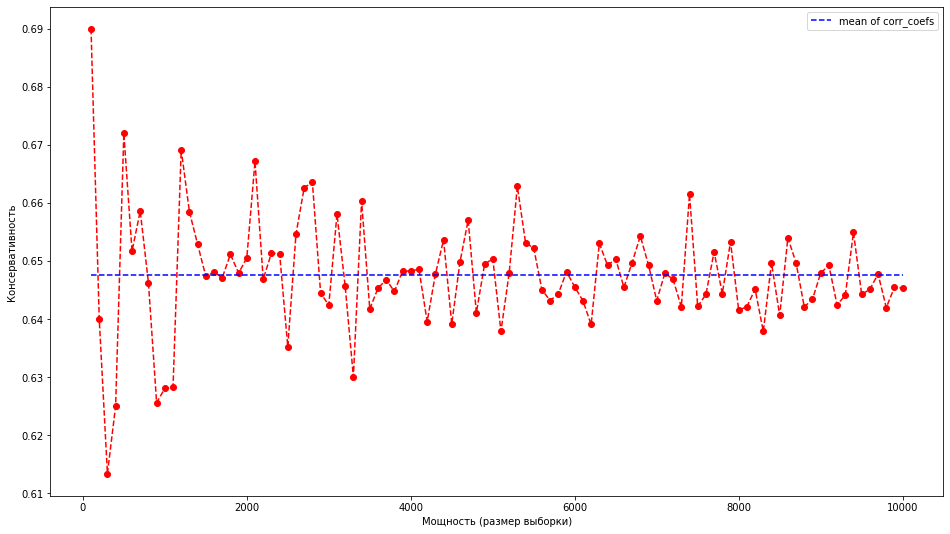

In [ ]:
figure(figsize = (16, 9))
plot(pow, res, 'ro--')
plot((min(pow), max(pow)), (np.mean(res), np.mean(res)), 'b--', label='mean of corr_coefs')
xlabel('Мощность (размер выборки)')
ylabel('Консервативность')
legend()

Как будто бы есть корреляция остатков

Теперь надо посмотреть на зависимость от коэффициента корреляции. Давайте пошатаем его немножко (изменением $\sigma$)

In [ ]:
def corr_finder(sigma: float):
    return 1 / np.sqrt(1 + sigma ** 2)

results_corr = []
tests = list(np.logspace(1e-3, 1, 100) - 1)
corr_coefs = list(map(lambda sigma: corr_finder(sigma), tests))

for sigma in tqdm(tests):
    results_corr.append(test_handler(1000, sample_size, sigma))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in arctanh
  # This is added back by InteractiveShellApp.init_path()


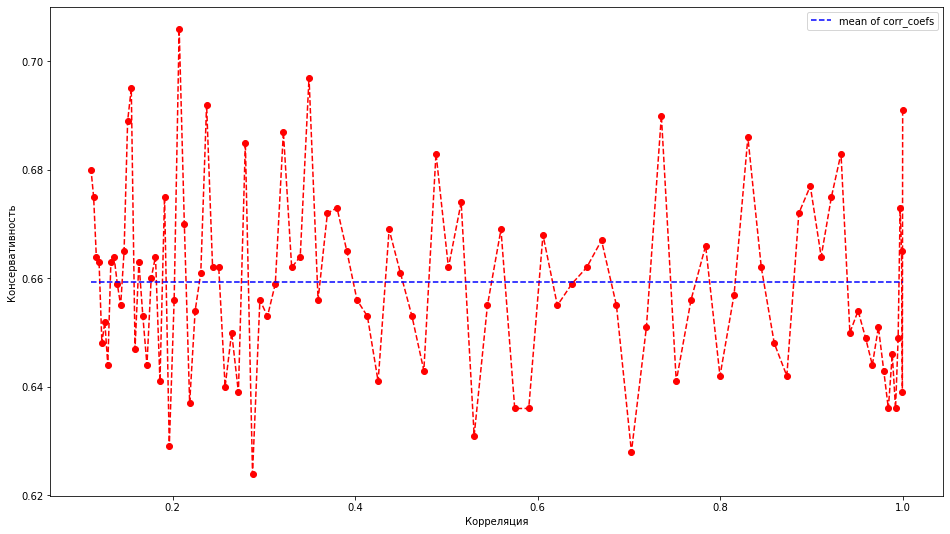

In [ ]:
figure(figsize = (16, 9))
plot(corr_coefs, results_corr, 'ro--')
plot((min(corr_coefs), max(corr_coefs)), (np.mean(results_corr), np.mean(results_corr)), 'b--', label='mean of corr_coefs')
xlabel('Корреляция')
ylabel('Консервативность')
legend()

Тут вообще как будто бы нет зависимости.

# Задание 2 (не сделано)
## Задача 2.2
[Выборка](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/labs/lab2/data/2.2.csv)

Требуется построить авторегрессионную модель (autoregressive moving-average model, ARMA) для данных предложенных в приложении.

- Записать задачу формально;
- Выписать все формулы аналитически;
- Провести вычисления всех параметров модели аналитически.

UPD: параметры p и q для ARMA можно оценить при помощи компьютера.

Все выкладки должны быть сделаны аналитически, без использования компьютера. Дополнительно к слайдам про ARMA можно почитать [здесь](https://math.unm.edu/~ghuerta/tseries/week4_1.pdf).

# Задание 3 (сделано)
## Задача 3.2
[Выборка](https://github.com/natasha/nerus): набор предложений на русском языке с указанием именованных сущностей (они же NE, named entity).

Требуется:

- Рассмотреть последовательность именованных и неименованных сущностей как марковскую модель. Определить оптимальный порядок марковской модели.
- Обучить скрытую марковскую модель по выборке. Оценить точность предсказания, является ли слово именованной сущностью или нет, посчитать энтропию на выборке.

Важно: в целях ускорения эксперимента рекомендуется взять первые 10 МБ текста из выборки.

### Загрузим датасет и поставим правильные версии библиотек

Тут везде флажки на тихую установку, потому что выводы wget и пепа занимают слишком много места

In [ ]:
!mkdir data -p
!wget https://storage.yandexcloud.net/natasha-nerus/data/nerus_lenta.conllu.gz -O data/nerus_lenta.conllu.gz -q
!pip install "nltk==3.4.5" ipymarkup nerus hurry.filesize -q

**Теперь надо перезагрузить runtime**, потому что мы поставили другую версию `nltk`, после чего импортнём нужные библиотеки

In [ ]:
from pandas import DataFrame
from nerus import load_nerus
import ipymarkup
from nltk.tag import hmm
from re import compile, Pattern
from sys import getsizeof
from hurry.filesize import size
from seaborn import heatmap
from matplotlib.pyplot import figure
from collections import Counter
from more_itertools import take
from scipy.stats.distributions import chi2
from nltk.lm import Laplace
from numpy import transpose, log, sum as nsum, unique as nunique

### Посмотрим на датасет поближе

Интересно, сколько же весит наша нерусь

In [ ]:
!du -sh data/*

1.9G	data/nerus_lenta.conllu.gz


In [ ]:
nerus_dataset = load_nerus('data/nerus_lenta.conllu.gz')

Поиграемся с датасетом: сначала посмотрим на то, как выглядит разметка в самом тексте

In [ ]:
next(nerus_dataset).ner.show()

Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в 
                                    PER─────────────               
каких регионах России зафиксирована наиболее высокая смертность от 
               LOC───                                              
рака, сообщает РИА Новости. По словам Голиковой, чаще всего 
               ORG────────            PER──────             
онкологические заболевания становились причиной смерти в Псковской, 
                                                         LOC──────  
Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-
LOC─────  LOC─────   LOC───────────────            LOC────────       
премьер напомнила, что главные факторы смертности в России — рак и 
                                                    LOC───         
болезни системы кровообращения. В начале года стало известно, что 
смертность от онкологических заболеваний среди россиян снизилась 
впервые за три года. По данным Росстата, в 2017 году от рак

Ничего не понятно, но очень интересно. Спасибо.

Посмотрим на морфологические даннные.

In [ ]:
sent = next(nerus_dataset).sents[0]
sent.morph.show()

         Австрийские  ADJ|Case=Nom|Degree=Pos|Number=Plur
  правоохранительные  ADJ|Case=Nom|Degree=Pos|Number=Plur
              органы  NOUN|Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur
                  не  PART|Polarity=Neg
         представили  VERB|Aspect=Perf|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act
       доказательств  NOUN|Animacy=Inan|Case=Gen|Gender=Neut|Number=Plur
           нарушения  NOUN|Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing
         российскими  ADJ|Case=Ins|Degree=Pos|Number=Plur
       биатлонистами  NOUN|Animacy=Anim|Case=Ins|Gender=Masc|Number=Plur
      антидопинговых  ADJ|Case=Gen|Degree=Pos|Number=Plur
              правил  NOUN|Animacy=Inan|Case=Gen|Gender=Neut|Number=Plur
                   .  PUNCT


Уже более понятно, но всё ещё не очень интересно.

Посмотрим на синтаксические данные, потому что я люблю стрелочки.

In [ ]:
sent.syntax.show()

    ┌──► Австрийские        amod
    │ ┌► правоохранительные amod
  ┌►└─└─ органы             nsubj
  │   ┌► не                 advmod
┌─└─┌─└─ представили        
│   └►┌─ доказательств      obj
│ ┌─┌─└► нарушения          nmod
│ │ │ ┌► российскими        amod
│ │ └►└─ биатлонистами      nmod
│ │   ┌► антидопинговых     amod
│ └──►└─ правил             nmod
└──────► .                  punct


### Пункт 1:
Рассмотреть последовательность именованных и неименованных сущностей как марковскую модель. Определить оптимальный порядок марковской модели.

Если не исключить всё кроме русского языка, появятся артефакты. Нам такое не надо, спасибо.

Будем обрабатывать токены, пока не заполним пресловутые 10мб памяти списком, заодно замеряв время этого действа.

Тут я учился вынимать токены из предложений. Неочевидно.

In [ ]:
next(nerus_dataset).sents[0].tokens[0].pos

'NOUN'

In [ ]:
def words_getter(rus_re: Pattern, mb_count: int, dataset) -> list:
    tokens = []
    megabyte_size = 1024 ** 2
    i = 0
    while getsizeof(tokens) < mb_count * megabyte_size:
        i += 1
        if not i % 1000:
            print(size(getsizeof(tokens)))
        for sent in next(dataset).sents:
            for token in sent.tokens:
                word = token.text.lower()
                pos = token.pos
                if russian.match(word):
                    tokens.append((word, pos))
    return tokens

In [ ]:
%%time
russian = compile('^[а-я]+$')

tokens = words_getter(russian, 10, nerus_dataset)
print(f"Number of tokens: {len(tokens)}, size of tokens: {size(getsizeof(tokens))}")

1M
2M
4M
5M
6M
8M
9M
Number of tokens: 1223231, size of tokens: 10M
CPU times: user 16.4 s, sys: 380 ms, total: 16.7 s
Wall time: 16.8 s


In [ ]:
tokens[:10]

[('с', 'ADP'),
 ('начала', 'NOUN'),
 ('расследования', 'NOUN'),
 ('российского', 'ADJ'),
 ('вмешательства', 'NOUN'),
 ('в', 'ADP'),
 ('выборы', 'NOUN'),
 ('власти', 'NOUN'),
 ('сша', 'PROPN'),
 ('потратили', 'VERB')]

In [ ]:
text = ' '.join(transpose(tokens)[0])
len(text), text[:100]

(943273,
 'по социальным вопросам татьяна голикова рассказала в каких регионах россии зафиксирована наиболее вы')

Посмотрим на текст поближе ради лулзов

In [ ]:
text[:1000]

'по социальным вопросам татьяна голикова рассказала в каких регионах россии зафиксирована наиболее высокая смертность от рака сообщает риа новости по словам голиковой чаще всего онкологические заболевания становились причиной смерти в псковской тверской тульской и орловской областях а также в севастополе напомнила что главные факторы смертности в россии рак и болезни системы кровообращения в начале года стало известно что смертность от онкологических заболеваний среди россиян снизилась впервые за три года по данным росстата в году от рака умерли тысяч человек это на процента меньше чем годом ранее австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых правил об этом сообщил посол россии в вене дмитрий любинский по итогам встречи уполномоченного адвоката дипмиссии с представителями прокуратуры страны передает тасс действует презумпция невиновности ограничений свободы передвижения для команды нет добавили в посольстве междуна

Сделаем русский словарик

In [ ]:
vocab = {word: pos for word, pos in tokens}
len(vocab)

28707

In [ ]:
def ngrams_and_prefix_counts(tokens, n_max):
    # словарь n-грамм и их частот
    ngrams_counts = {}
    # словарь n-граммных префиксов и их частот
    prefix_counts = {}
    
    n = len(tokens)
    for i in range(n_max):
        ngrams_counts[i + 1] = Counter([tuple(tokens[j : j + i + 1]) for j in range(n - i)])
        prefix_counts[i + 1] = Counter([tuple(tokens[j : j + i] + ['*']) for j in range(n - i)])

    return ngrams_counts, prefix_counts

Так сжирался RAM...

In [ ]:
ngram_counts, prefix_counts = ngrams_and_prefix_counts(tokens, 3)

In [ ]:
def unigram_probas(ngram_counts):
    """
    gets probabilities of unigrams in text
    """
    p1 = {}
    n = sum(ngram_counts[1].values())
    for w in ngram_counts[1]:
        p1[w] = ngram_counts[1][w] / n
    return p1


def bigram_probas(ngram_counts, prefix_counts):
    """
    gets probabilities of bigrams in text
    """
    p2 = {}
    for w in ngram_counts[2]:
        pre_w = tuple([w[0]] + ['*'])
        p2[u'{1}|{0}'.format(*w)] = ngram_counts[2][w] / prefix_counts[2][pre_w]
    return p2


def trigram_probas(ngram_counts, prefix_counts):
    """
    gets probabilities of trigrams in text
    """
    p3 = {}
    for w in ngram_counts[3]:
        pre_w = w[:2] + tuple(['*'])
        p3[u'{2}|{1},{0}'.format(*w)] = ngram_counts[3][w] / prefix_counts[3][pre_w]
    return p3

Посмотрим на рандомные 10 значений словаря, чтобы удостовериться, что всё нормально

In [ ]:
def random_n_dict_items(d: dict, n: int) -> dict:
    """gets random n items of a sorted dict by values"""
    return [(d[x], x) for x in take(n, d)]

In [ ]:
p1 = unigram_probas(ngram_counts)
random_n_dict_items(p1, 10)

[(0.0500281631188222, (('в', 'ADP'),)),
 (0.0018786312642501703, (('сша', 'PROPN'),)),
 (9.728334223053536e-05, (('появился', 'VERB'),)),
 (0.021188148436395087, (('на', 'ADP'),)),
 (4.823291757648392e-05, (('свет', 'NOUN'),)),
 (4.08753538783762e-06, (('аномально', 'ADV'),)),
 (1.5532634473782957e-05, (('маленький', 'ADJ'),)),
 (4.08753538783762e-06, (('теленок', 'NOUN'),)),
 (0.0033517790180268487, (('как', 'SCONJ'),)),
 (0.002210539137742585, (('сообщает', 'VERB'),))]

In [ ]:
p2 = bigram_probas(ngram_counts, prefix_counts)
random_n_dict_items(p2, 10)

[(0.004624485260474541, "('сша', 'PROPN')|('в', 'ADP')"),
 (0.0004351610095735422, "('появился', 'VERB')|('сша', 'PROPN')"),
 (0.23529411764705882, "('на', 'ADP')|('появился', 'VERB')"),
 (0.0004629986881703835, "('свет', 'NOUN')|('на', 'ADP')"),
 (0.01694915254237288, "('аномально', 'ADV')|('свет', 'NOUN')"),
 (0.2, "('маленький', 'ADJ')|('аномально', 'ADV')"),
 (0.05263157894736842, "('теленок', 'NOUN')|('маленький', 'ADJ')"),
 (0.2, "('как', 'SCONJ')|('теленок', 'NOUN')"),
 (0.037317073170731706, "('сообщает', 'VERB')|('как', 'SCONJ')"),
 (0.10687869822485208, "('издание', 'NOUN')|('сообщает', 'VERB')")]

In [ ]:
p3 = trigram_probas(ngram_counts, prefix_counts)
random_n_dict_items(p3, 10)

[(0.0035335689045936395, "('появился', 'VERB')|('сша', 'PROPN'),('в', 'ADP')"),
 (1.0, "('на', 'ADP')|('появился', 'VERB'),('сша', 'PROPN')"),
 (0.10714285714285714, "('свет', 'NOUN')|('на', 'ADP'),('появился', 'VERB')"),
 (0.08333333333333333, "('аномально', 'ADV')|('свет', 'NOUN'),('на', 'ADP')"),
 (1.0, "('маленький', 'ADJ')|('аномально', 'ADV'),('свет', 'NOUN')"),
 (1.0, "('теленок', 'NOUN')|('маленький', 'ADJ'),('аномально', 'ADV')"),
 (1.0, "('как', 'SCONJ')|('теленок', 'NOUN'),('маленький', 'ADJ')"),
 (1.0, "('сообщает', 'VERB')|('как', 'SCONJ'),('теленок', 'NOUN')"),
 (0.3006535947712418,
  "('издание', 'NOUN')|('сообщает', 'VERB'),('как', 'SCONJ')"),
 (0.0034602076124567475,
  "('новорожденное', 'ADJ')|('издание', 'NOUN'),('сообщает', 'VERB')")]

Впору уже свой пакет писать для этой лабы ><

In [ ]:
def chi2_statistic(p_small, p_big, tokens, model_type: str):
    """
    gets chi2 stat for the hypothesis that we can reduce
    the bigram model to the monogram one
    """
    stat_small = []
    stat_big = []
    n = len(tokens)
    for i in range(n - 2):
        if model_type == "3_to_2":
            w = tokens[i : i + 3]
            ngram_big = '{2}|{1},{0}'.format(*w)
            ngram_small = '{1}|{0}'.format(*w)
        elif model_type == "2_to_1":
            w = tokens[i : i + 2]
            ngram_big = '{1}|{0}'.format(*w)
            ngram_small = '{0}'.format(*w)
        else:
            raise ValueError("unrecognized model type")

        try:
            stat_small.append(log(p_small[ngram_small]))
        except KeyError:
            stat_small.append(log(1e-20))
        try:
            stat_big.append(log(p_big[ngram_big]))
        except KeyError:
            stat_big.append(log(1e-20))
    return - 2 * nsum(stat_small) + 2 * nsum(stat_big)

In [ ]:
stat_32 = chi2_statistic(p2, p3, tokens, model_type="3_to_2")
print(f'p-value of a chi2 test that we can reduce tri-gram to bi-gram model: {1 - chi2(len(p3) * ((len(p3) - 1) ** 2) - 1).cdf(stat_32):.2f}')

p-value of a chi2 test that we can reduce tri-gram to bi-gram model: 1.00


Сведём ещё и биграммы к монограммам, а чёб нет

In [ ]:
stat_21 = chi2_statistic(p1, p2, tokens, model_type="2_to_1")
print(f'p-value of a chi2 test that we can reduce bi-gram to mono-gram model: {1 - chi2(len(p2) * ((len(p2) - 1) ** 2) - 1).cdf(stat_21):.2f}')

p-value of a chi2 test that we can reduce bi-gram to mono-gram model: 1.00


Прикольно, выходит, что оптимальная модель имеет первый порядок

### Пункт 2:
Обучить скрытую марковскую модель по выборке. Оценить точность предсказания, является ли слово именованной сущностью или нет, посчитать энтропию на выборке.

In [ ]:
!pip install nltk -U -q

Тут у меня постоянно крашилась сессия из-за того, что моделька во время разметки переполняла RAM, поэтому я буду обучать на 1мб слов.
Крашилась она к концу, поэтому есть возможность попытать счастья где-то на на 0.8мб

In [ ]:
nerus_dataset = load_nerus('data/nerus_lenta.conllu.gz')

In [ ]:
train_data = words_getter(russian, 10, nerus_dataset)

1M
2M
4M
5M
6M
8M
9M


In [87]:
trainer = hmm.HiddenMarkovModelTrainer([])
tagger = trainer.train_supervised([train_data])

In [103]:
tagger

<HiddenMarkovModelTagger 17 states and 102863 output symbols>

Проверим, работает ли оно вообще

In [105]:
%%time
train_res = tagger.test([train_data[:len(train_data) // 200]], verbose=True)

Test: по/ADP социальным/ADJ вопросам/NOUN татьяна/PROPN голикова/PROPN рассказала/VERB в/ADP каких/DET регионах/NOUN россии/PROPN зафиксирована/VERB наиболее/ADV высокая/ADJ смертность/NOUN от/ADP рака/NOUN сообщает/VERB риа/PROPN новости/PROPN по/ADP словам/NOUN голиковой/PROPN чаще/ADV всего/PRON онкологические/ADJ заболевания/NOUN становились/VERB причиной/NOUN смерти/NOUN в/ADP псковской/ADJ тверской/ADJ тульской/ADJ и/CCONJ орловской/ADJ областях/NOUN а/CCONJ также/ADV в/ADP севастополе/PROPN напомнила/VERB что/SCONJ главные/ADJ факторы/NOUN смертности/NOUN в/ADP россии/PROPN рак/NOUN и/CCONJ болезни/NOUN системы/NOUN кровообращения/NOUN в/ADP начале/NOUN года/NOUN стало/VERB известно/ADJ что/SCONJ смертность/NOUN от/ADP онкологических/ADJ заболеваний/NOUN среди/ADP россиян/NOUN снизилась/VERB впервые/ADV за/ADP три/NUM года/NOUN по/ADP данным/NOUN росстата/PROPN в/ADP году/NOUN от/ADP рака/NOUN умерли/VERB тысяч/NOUN человек/NOUN это/PRON на/ADP процента/NOUN меньше/NUM чем/SCONJ

Короче, на трейне эта штука даёт хороший результат. Не может не радовать.

Если использовать больше 1 мб в тестовой дате, выходит оверфлов по оперативной памяти

In [88]:
test_data = words_getter(russian, 0.5, nerus_dataset)

In [89]:
test_data[:4]

[('гражданина', 'NOUN'),
 ('россии', 'PROPN'),
 ('находившегося', 'VERB'),
 ('в', 'ADP')]

In [90]:
%%time
test_res = tagger.test([test_data], verbose=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Entropy: -3.385999999999953e+303

------------------------------------------------------------
accuracy over 64419 tokens: 14.46
CPU times: user 4min 18s, sys: 6.18 s, total: 4min 24s
Wall time: 4min 17s


Очень маленькая энтропия (что, вроде, плохо) и акуратность около 15%, что, в целом, неплохо, учитывая что это автоматические параметры.

Ноутбук решил, что вывод строки слишком большой и отказалась это делать. Ок, давайте разметим вручную, а потом сравним количество токенов с тестом, например

In [97]:
tagged_test = tagger.tag(list(transpose(test_data)[0]))

In [100]:
unique, counts = nunique(transpose(tagged_test)[1], return_counts=True)
tagged_dict = dict(zip(unique, counts))
unique, counts = nunique(transpose(test_data)[1], return_counts=True)
test_dict = dict(zip(unique, counts))

In [102]:
for key in test_dict.keys():
    try:
        print(f"test: {test_dict[key]}, model: {tagged_dict[key]} ocurrencies of {key}")
    except KeyError:
        print(f"test: {test_dict[key]}, model: 0 ocurrencies of {key}")

test: 6538, model: 0 ocurrencies of ADJ
test: 9317, model: 64419 ocurrencies of ADP
test: 2090, model: 0 ocurrencies of ADV
test: 556, model: 0 ocurrencies of AUX
test: 1869, model: 0 ocurrencies of CCONJ
test: 1343, model: 0 ocurrencies of DET
test: 3, model: 0 ocurrencies of INTJ
test: 22056, model: 0 ocurrencies of NOUN
test: 596, model: 0 ocurrencies of NUM
test: 981, model: 0 ocurrencies of PART
test: 2866, model: 0 ocurrencies of PRON
test: 5417, model: 0 ocurrencies of PROPN
test: 1388, model: 0 ocurrencies of SCONJ
test: 9376, model: 0 ocurrencies of VERB
test: 23, model: 0 ocurrencies of X


Вывод: получается, модель переобучилась под трейн и не годна в реальной жизни. Но хотя бы не записала все слова в неименованные сущности.

# Задание 4 (сделано)
## Задача 4.1
На основе представленной ниже языковой модели требуется:

- Выбрать наиболее вероятную последовательность слов, которая начинается со слова `<start>` и заканчивается словом `<end>`.
- Выбрать последовательность токенов, которая начинается со слова `<start>` и заканчивается словом `<end>` и имеет максимальный `score` = $\frac{1}{l}\sum_{i=1}^{l} \log p(w_i|w_{i-1})$, где $l$ задает длину полученной последовательности.

```
p(обучение|<start>)=0.14
p(<end>|машинный)=0.5
p(<end>|обучение)=0.5
p(не|обучение)=0.5
p(без|возможно)=0.5
p(без|<start>)=0.14
p(не|<start>)=0.14
p(<end>|без)=0.5
p(<end>|не)=0.5
p(обучение|машинный)=0.5
p(<end>|статистика)=1.0
p(возможно|не)=0.5
p(возможно|<start>)=0.14
p(машинный|<start>)=0.29
p(статистика|<start>)=0.14
p(статистика|без)=0.5
p(<end>|возможно)=0.5
```

Все выкладки должны быть сделаны аналитически, без использования компьютера. Важно: решением при помощи полного перебора не будет оцениваться в полный балл.

1. 
- Во-первых, $P(<start>, w_2, \dots, <end>) = P(w_2|<start>) 
\times P(w_3|w_2) \times \dots \times P(w_{l-1}|<end>)$

- Во-вторых, $P(w_i|w_j) = 0.5$ при $j \ne 1, i \ne l$, кроме переходов от первого слова и переходов к последнему слову.

- Тогда, если $l$ — длина предложения, то его вероятность получается равной
$$P = P(w_2|<start>) \times 0.5^{l-2} \times P(<end>|w_{l-1})$$

- $P(w_2|<start>) = 0.14$ всегда, кроме случая $w_2=\text{машинный}$: $P(машинный|<start>) = 0.29$.

- Рассмотрим этот случай подробнее:
$$P = 0.29 \times 0.5^{l-2} \times P(<end>|w_{l-1}) $$

    - Если взять $l=2$, выходит:
$$P(<start>машинное<end>) = 0.29 \times 0.5$$

    - При $l>2$ получается:
$$P = 0.29 *0.5 * 0.5^{l-2}* P(<end>|w_{l-1}) \le 0.29 *0.5 * 0.5^{l-2} \le 0.29 *0.5  $$

- Так, если слово "машинное" второе в предложении, наиболее вероятным предложением является $<start>машинное<end>$.

- Если же второе место в предложении занимает другое слово, то
$$P = 0.14 \times 0.5^{l-2} \times P(<end>|w_{l-1})  \leqslant 0.14 \times 1 \times 1$$

- **Но!** Это меньше чем $0.5 \times 0.29 = P(<start>машинное<end>)$.

Значит, наиболее вероятное предложение: $P(<start>машинное<end>)$

2.
- `score`:

$$ S = \frac{1}{l}\sum_{i=1}^{l} \log p(w_i|w_{i-1}) = log(^l\sqrt{P}) =$$ $$= log(^l \sqrt{P(w_2|<start>) * 0.5^{l-2}* P(<end>|w_{l-1})} = log(^l \sqrt{p* 0.5^{l-2})},$$ 
$$\text{где } p = P(w_2|<start>) \times P(<end>|w_{l-1})$$

- Очевидно, что максимум достигается при $l = \arg\max p $
$$ p \le max (P(w_2|<start>)) \times max (P(<end>|w_{l-1})) = 0.28 \times 0.1 = 0.28$$

- Эта граница достигается при $l=7$ и предложение "start машинный обучение" невозможно без статистики "end".

- Значит, это и есть предложение с наибольшим `score`.